In [3]:
%matplotlib inline

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import model_selection as cv
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.datasets import load_digits
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

from statsmodels.stats.proportion import proportion_confint
import sklearn.neighbors as nb

In [7]:
data = pd.read_csv('data_balanced_normalized.csv')
data.head()
X = data.drop('heart_attack',axis=1)
y = data['heart_attack']
# as a first approach, we will use the standard of 70/30 train/test split (in the future we might adjust it)
(X_train, X_test,  y_train, y_test) = cv.train_test_split(X, y, test_size = .3, random_state = 1)

# Decision Tree
## train data -> default values like 4 and 0.02



0.793172216536776
[[15347  3742]
 [ 4140 14880]]

Accuracy: 0.793172216536776

              precision    recall  f1-score   support

           0       0.79      0.80      0.80     19089
           1       0.80      0.78      0.79     19020

    accuracy                           0.79     38109
   macro avg       0.79      0.79      0.79     38109
weighted avg       0.79      0.79      0.79     38109



<Figure size 640x480 with 0 Axes>

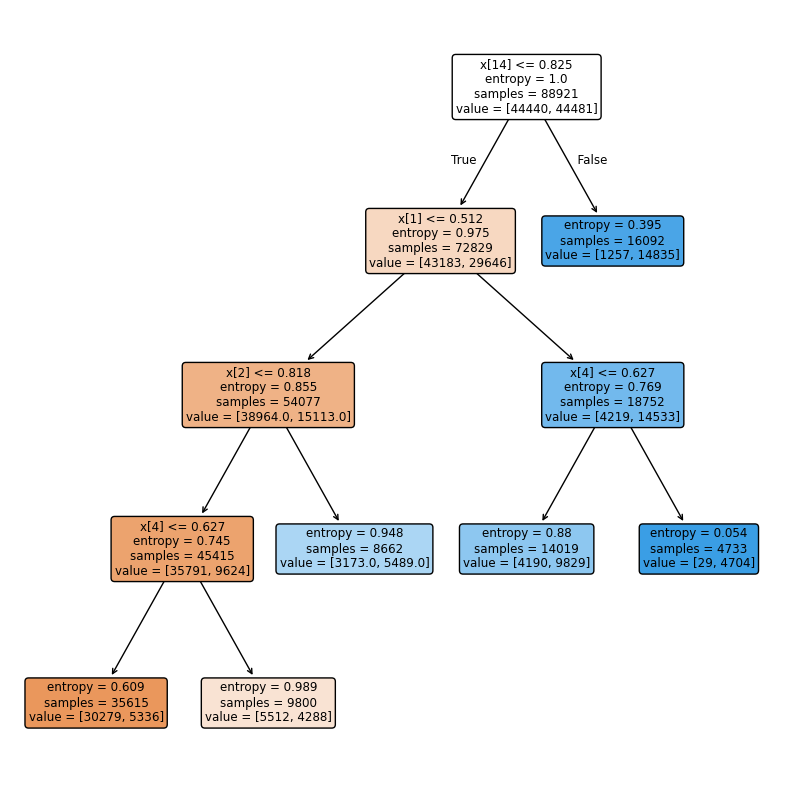

In [13]:
clf = DecisionTreeClassifier(
    criterion = "entropy",
    min_samples_split = 4,
    min_impurity_decrease = 0.02
)
clf = clf.fit(X_train, y_train)
prediction = clf.predict(X_test)

print(clf.score(X_test, y_test))
print(confusion_matrix(y_test, prediction))
print(f"\nAccuracy: {accuracy_score(y_test, prediction)}\n")
print(classification_report(y_test, prediction))
epsilon = accuracy_score(y_test, prediction)

fig = plt.gcf()
#fig.set_size_inches(800, 80)
plt.figure(figsize=(10,10))
plot_tree(clf, filled=True, rounded=True)
#fig.savefig("tree.png")
plt.show()

## values found with GridSearchCV

In [17]:
from sklearn.model_selection import GridSearchCV

params = {
    "min_impurity_decrease": list(np.linspace(0,0.5,21)),
    "min_samples_split":list(range(2,20,11))
}
clf = GridSearchCV(
    DecisionTreeClassifier(criterion = "entropy"),
    param_grid = params,
    cv = 10,  # OBS: # If cv is integer, by default is Stratifyed
    n_jobs = -1
)
clf.fit(X_train, y_train)
print(f"Best Params = {clf.best_params_}  -  Accuracy = {clf.best_score_}")

Best Params = {'min_impurity_decrease': np.float64(0.0), 'min_samples_split': 13}  -  Accuracy = 0.8171072827197987


## train data with values more suitable for our model (from GridSearchCV)

In [ ]:
cdt= DecisionTreeClassifier(
    criterion = "entropy",
    min_samples_split = clf.best_params_["min_samples_split"],
    min_impurity_decrease = clf.best_params_["min_impurity_decrease"]
)
clf = cdt.fit(X_train, y_train)
pred = clf.predict(X_test)

# Obtain accuracy score of learned classifier on test data
print(f"prediction: {[pred]}")
print(clf.score(X_test, y_test))
print(confusion_matrix(y_test, pred))
print(f"\nAccuracy: {accuracy_score(y_test, pred)}\n")
print(classification_report(y_test, pred))

epsilon = accuracy_score(y_test, pred)
print(epsilon)

fig = plt.gcf()
#fig.set_size_inches(800, 80)
plt.figure(figsize=(10, 10))
plot_tree(clf, filled=True, rounded=True)
#fig.savefig("tree.png")
plt.show()
#print("Interval of confidence:", proportion_confint(count=epsilon*X_test.shape[0], nobs=X_test.shape[0], alpha=0.05, method='binom_test'))

prediction: [array([1, 0, 0, ..., 0, 1, 0])]
0.816132672072214
[[15680  3409]
 [ 3598 15422]]

Accuracy: 0.816132672072214

              precision    recall  f1-score   support

           0       0.81      0.82      0.82     19089
           1       0.82      0.81      0.81     19020

    accuracy                           0.82     38109
   macro avg       0.82      0.82      0.82     38109
weighted avg       0.82      0.82      0.82     38109

0.816132672072214


<Figure size 640x480 with 0 Axes>